In [80]:
# Imports, sane defaults
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
plt.rcParams['figure.dpi'] = 200
plt.rcParams['axes.grid'] = True
plt.rcParams['image.aspect'] = 0.6

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Symbolic variables, expressions, and functions

A *symbolic variable* is either `ca.SX.sym` or `ca.MX.sym`[1], which does not have a numerical value, it is simply a placeholder used to define expressions and functions.  It serves to track the operations in the functions so they can be later differentiated, numerically evaluated.

A CasADi *expression* is an arbitrary combination of symbolic variables and elementary operations, see [the documentation](https://web.casadi.org/python-api/#module-casadi.casadi). An expression can be differentiated with respect to any of the symbolic variables in it.

A CasADi *function* is an object which maps some symbolic variables to an expression [2]. This expression must _only_ depend on the symbolic variables.  A function can be evaluated for numerical or symbolic input [3].


[1] `SX` and `MX` are computationally and memory optimized, respectively, and are treated slightly differently in the computational graph. All CasADi native operations are defined over both, but they cannot be mixed in an expression. In my experience, `SX` was more efficient, but depends on problem characteristics.

[2] A CasADi function lives in a (C++) virtual machine, and while building it is relatively expensive, evaluation of it or its gradients is rather efficient.

In [19]:
# Let's make some variables!
sym = ca.SX.sym
x = sym('x', 4)     # arguments are name and dimension
print(f"Symbolic var: {x}")
y = sym('y', 2, 4)  # 2x4 matrix
print(f"Matrix sym var: {y}")

# Let's make an expression
z = y@x
print(f"Expression: {z}")
z = ca.cos(z)   # CasADi can map an oversized input, but be careful because sometimes unexpected dimension handling
z = ca.exp(z)
z = ca.norm_2(z)

# Let's differentiate an expression
jac_x = ca.jacobian(z, x)
print(f"Jacobian wrt x shape: {jac_x.shape}")

# Let's make a function, arguments are (name, [in], [out])
fn = ca.Function('fn', [x, y], [z])
print(f"Function: {fn}")

# Let's evaluate a function
x_num = [0.1, 0.2, 0.3, 0.4]
y_num = ca.DM.zeros(2,4)
y_num[0,1] = 2.3
print(f"Function eval: {fn(x_num,y_num)}")


Symbolic var: [x_0, x_1, x_2, x_3]
Matrix sym var: 
[[y_0, y_2, y_4, y_6], 
 [y_1, y_3, y_5, y_7]]
Expression: [((((y_0*x_0)+(y_2*x_1))+(y_4*x_2))+(y_6*x_3)), ((((y_1*x_0)+(y_3*x_1))+(y_5*x_2))+(y_7*x_3))]
Jacobian wrt x: (1, 4)
Function: fn:(x[4],y[2x4])->(z) SXFunction
Function eval: 3.65939


In [160]:
# from robot import Robot
robot = Robot('franka.urdf')
nq = robot.nq
q0 = [0.3, 0.2, 0.5, 0.3, 0.2, 0.5, 0.3]
ee_pose = robot.fwd_kin(q0)
print(f"EE position: {ee_pose[0]}")
print(f"EE orientation: {ee_pose[1]}")

# Find the Jacobian matrix for the forward dynamics, make a function
q_sym = ca.SX.sym('q', nq)
ee_sym = robot.fwd_kin(q_sym)
jac_sym = ca.jacobian(ee_sym[0], q_sym)
jac_fn = ca.Function('jac_sym', [q_sym], [jac_sym])

# Check if it makes sense
pert = 1e-3
ind = 0
q_pert = q0
q_pert[ind] += pert
ee_pose_pert = robot.fwd_kin(q_pert)
jac_num = (ee_pose_pert[0]-ee_pose[0])/pert
jac = jac_fn(q0)[:,ind]
print(f"Symbolic: {jac}")
print(f"Numeric:  {jac_num}")
assert all(np.isclose(jac_1_num, jac_1, rtol=1e-1, atol = 1e-1)), "Something terrible happened"


Building robot model from franka.urdf
EE position: [0.12214, 0.0741982, 0.964338]
EE orientation: 
[[0.699467, 0.656947, 0.281365], 
 [0.457473, -0.714054, 0.529948], 
 [0.549058, -0.241963, -0.799993]]
Symbolic: [-0.0743203, 0.122066, 00]
Numeric:  [-0.0742593, 0.122103, 0]


# Optimization problem in CasADi
An optimization problem in CasADi is defined by
  - `x`: the decision variables, a vector of symbolic variables which will be optimized
  - `p`: parameters, a vector of symbolic variables which will _not_ be optimized, but can take different numerical values without re-building the problem. Used for, e.g. current state.
and a `dict` of expressions defined over `x` and `p`:
  - `f`: objective, a scalar expression which will be minimized
  - `g`: constriaints, a vector expression which will be constrained by `lbg < g < ubg`

Once defined, the problem can be solved, given a `dict` of numerical info
  - `x0`: initial guess for the optimal `x`
  - `lbx`: lower bound for `x`
  - `ubx`: upper bound for `x`
  - `p`: the numerical value of the parameters `p`
  - `lbg`: lower bound for constraints `g`
  - `ubg`: upper bound for constraints `g`
  
Tricks:
  - When imposing equality constraints, set `lbg` and `ubg` to be `0` for that respective constraint.
  - When a lower/upper bound is omitted, it's -/+ infty, respectively.
  - Often an `x0` at `0` can blow up the gradients, you'll see an error like 'can't calculate multipliers'
  - You'll see lam_{x0, g0, x, g, p}, these are the lambdas in the Lagrangian to enforce the constraints.  Helpful in warm starts but can ignore at the beginning
  
Let's practice by helping a lazy robot, who wants the highest speed $\Vert\dot{x}\Vert$ for a joint speed $\Vert \dot{q} \Vert < 1$. We'd like to solve this problem for a range of numerical joint positions $q_1, \dots$ without rebuilding the optimization problem.  

In [91]:
q = ca.SX.sym('q', nq)
dq = ca.SX.sym('dq', nq)

dx = jac_fn(q)@dq
prob = {'x': dq,
        'p': q,
        'f': -ca.norm_2(dx),
        'g': ca.norm_2(dq),}
solver = ca.nlpsol('solver', 'ipopt', prob, {'ipopt.print_level':5})
print(f"Built {solver}")


args = {'x0': ca.DM.ones(nq),
        'p': q0,
        'ubg': 1}
solution = solver(**args)
print(f"Optimal joint velocity of {solution['x']}")


Built solver:(x0[7],p[7],lbx[7],ubx[7],lbg,ubg,lam_x0[7],lam_g0)->(x[7],f,g,lam_x[7],lam_g,lam_p[7]) IpoptInterface
This is Ipopt version 3.11.9, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        7
Number of nonzeros in Lagrangian Hessian.............:       28

Total number of variables............................:        7
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        1
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with 

# MPC with multiple shooting

A multiple-shooting MPC problem is a type of optimization problem, where we have a decision variable for each state in the trajectory, and enforce the dynamics by constraints. The ingredients this recipe:

  - Discrete-time dynamics which give $x^+ = f(x,u)$. This probably means you need to write an integrator.
  - A cost function which maps $x,u\rightarrow \mathbb{R}$. Your objective function `f` will probably be the sum of this over the time steps
  
  
## Tricks
  - You'll probably want a parameter for initial state $x_0$, because we want to call the MPC from the current system state
  - Warm starts help a lot - setting x0 (and lam_x0, lam_g0) to the result from the previous optimization problem

In [166]:
# Initialize an empty optimization problem
mpc_steps = 30

step = robot.build_disc_dyn(step_size=0.1)

# Set up 
x = ca.SX.sym('x', 2*nq, mpc_steps-1)
x0 = ca.SX.sym('x0', 2*nq)
tau = ca.SX.sym('tau', nq, mpc_steps)

x_aug = ca.horzcat(x0,x)

x_next = step(x_aug, tau)

ee_poses = robot.fwd_kin(x_next[:nq,:])

# Define problem
prob = {'x': ca.vertcat(ca.reshape(x,-1,1), ca.reshape(tau, -1,1)),
        'p': x0,
        'f': ca.sumsqr(ee_poses[0]-[0.3, 0.3, 0.3]) + 1e-4*ca.sumsqr(tau),
        'g': ca.reshape(x_next[:,:-1]-x,-1,1)}


solver = ca.nlpsol('solver', 'ipopt', prob, {'ipopt.print_level':0, 'print_time': False})
print(f"Build solver {solver}")

args = {'x0': ca.DM.ones(2*nq*(mpc_steps-1)+nq*mpc_steps,1),
        'p': ca.vertcat(q0, ca.DM.zeros(nq)),
        'lbg': 0,
        'ubg': 0}

solution = solver(**args)
print(f"Solution found")
x_traj = ca.reshape(solution['x'][:2*nq*(mpc_steps-1)], 2*nq, mpc_steps-1)
tau_traj = ca.reshape(solution['x'][-nq*mpc_steps:], nq, mpc_steps)

Build solver solver:(x0[616],p[14],lbx[616],ubx[616],lbg[406],ubg[406],lam_x0[616],lam_g0[406])->(x[616],f,g[406],lam_x[616],lam_g[406],lam_p[14]) IpoptInterface
Solution found


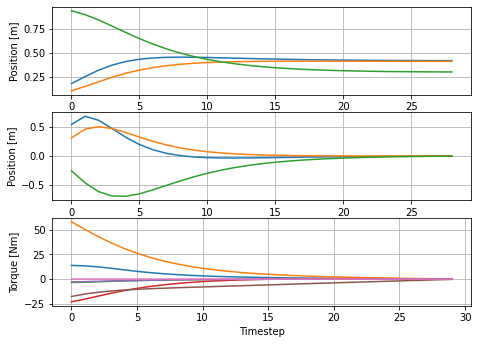

In [167]:
pos, vel = robot.tcp_motion(x_traj[:nq,:], x_traj[nq:,:])

fig = plt.figure(figsize=(7.5, 5.5))
plt.subplot(3,1,1)
plt.plot(pos.T)
plt.ylabel('Position [m]')
plt.xlabel('Timestep')

plt.subplot(3,1,2)
plt.plot(vel.T)
plt.ylabel('Position [m]')
plt.xlabel('Timestep')

plt.subplot(3,1,3)
plt.plot(tau_traj.T)
plt.ylabel('Torque [Nm]')
plt.xlabel('Timestep')

plt.show()